# NAIRU Model

Modelling the non-accelerating inflation rate of unemployment (NAIRU) for the Australian economy, using a variant of one of the RBA's approaches. Largely for exploratory purposes only.

#### Acknowledgements

This work has drawn on ideas and approaches in the following:

Most useful:

 * https://www.rba.gov.au/publications/bulletin/2017/jun/pdf/bu-0617-2-estimating-the-nairu-and-the-unemployment-gap.pdf (Tom Cusbert)

 * https://treasury.gov.au/sites/default/files/2021-04/p2021-164397_estimatingthenairuinaustralia.pdf

 * https://github.com/MacroDave/NAIRU

 * https://gross.substack.com/p/navigating-the-nairu?utm_source=publication-search

Also useful:

 * https://www.rba.gov.au/education/resources/explainers/pdf/nairu.pdf?v=2024-05-09-14-09-00

 * https://www.rbnz.govt.nz/-/media/project/sites/rbnz/files/publications/analytical-notes/2018/an2018-04.pdf

 * https://cmr.uni-koeln.de/fileadmin/wiso_fak/cmr/pdf/Berger_Publication_list/nairu.pdf

## Python set-up

In [1]:
# system imports
from typing import cast


In [2]:
# Analtic imports
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm  # type: ignore[import-untyped]
import matplotlib.pyplot as plt
from IPython.display import display
from readabs import read_abs_series, read_rba_table

In [3]:
# local imports
import mgplot as mg 
import henderson
from abs_structured_capture import ReqsDict, ReqsTuple, get_abs_data
from pymc_helper import (
    check_for_zero_coeffs,
    check_model_diagnostics, 
    get_scalar_var, 
    get_vector_var,
    plot_posteriors_bar,
    plot_posteriors_kde,
)

In [4]:
# Plotting set-up
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/NAIRU/"
mg.set_chart_dir(CHART_DIR)
mg.clear_chart_dir()

RFOOTER = "ABS: 1364.0.15.003"

# display charts in this notebook
SHOW = False

## Data capture

#### Utility

In [5]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of
    the three months in each quarter. Ignore quarters with less than
    three months data. Drop NA items."""

    return (
        data.groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(["mean", "count"])
        .apply(lambda x: x["mean"] if x["count"] == 3 else np.nan, axis=1)
        .dropna()
    )

In [6]:
# plot the 2.5% annual inflation target in quarterly terms

QUARTERLY_TARGET = {
    "axhline": {
        "y": (pow(1.025, 0.25) - 1) * 100,
        "linestyle": "dashed",
        "linewidth": 0.75,
        "color": "darkred",
        "label": "Quarterly growth consistent with 2.5% annual inflation",
    }
}

QUARTERLY_RANGE = {
    "axhspan": {
        "ymin": (pow(1.02, 0.25) - 1) * 100,
        "ymax": (pow(1.03, 0.25) - 1) * 100,
        "color": "#ffdddd",
        "label": "Quarterly growth consistent with 2-3% annual inflation target",
        "zorder": -1,
    }
}

ANNUAL_RANGE = {
    "axhspan": {
        "ymin": 2,
        "ymax": 3,
        "color": "#dddddd",
        "label": "2-3% annual inflation target range",
        "zorder": -1,
    }
}

ANNUAL_TARGET = {
    "axhline": {
        "y": 2.5,
        "linestyle": "dashed",
        "linewidth": 0.75,
        "color": "darkred",
        "label": "2.5% annual inflation target",
    }
}

#### Unemployment rate

In [7]:
def get_unemployment() -> tuple[pd.Series, pd.Series, pd.Series]:
    """Get the unemployment related data from the ABS and
    calculate the UE rate, and the change in the UE rate."""

    wanted: ReqsDict = {
        # ReqsTupleL cat, table, did, stype, unit, seek_yr_growth, calc_growth, zip_file
        "Labor Force": 
            ReqsTuple("1364.0.15.003", "1364015003", "Total labour force ;", "S", "", False, False, ""),
        "Unemployed":
            ReqsTuple("1364.0.15.003", "1364015003", "Total unemployed ;", "S", "", False, False, ""),
    }
    data = get_abs_data(wanted)
    u = (data["Unemployed"] / data["Labor Force"]) * 100

    # calculate the change in the UE rate as a proportion of the UE rate
    delta_u = u.diff(1)
    delta_u_1 = delta_u.shift(1)

    # Plot the data
    common_format = {
        "lfooter": "Australia. Seasonally adjusted series. Quarterly data. ",
        "rfooter": RFOOTER,
        "show": SHOW,
        "y0": True,
    }

    mg.line_plot_finalise(
        u,
        title="Unemployment rate",
        ylabel="Per cent of Labour Force",
        **common_format,
    )

    mg.line_plot_finalise(
        delta_u,
        title="Change in the unemployment rate (ΔU)",
        ylabel="Q/Q Percentage points",
        **common_format,
    )

    # return the values
    return u, delta_u, delta_u_1


U, ΔU, ΔU_1 = get_unemployment()

#### Inflation

In [8]:
def annual_to_quarterly(annual_rate: pd.Series) -> pd.Series:
    """Convert annual inflation expectations to quarterly.
    Formula: ((1 + annual_rate/100)^(1/4) - 1) * 100"""
    return ((1 + annual_rate / 100) ** (1/4) - 1) * 100

In [9]:
def get_inflation(measure="TM"
) -> tuple[pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series]:
    """Get trimmed mean inflation as a measure of core inflation."""

    # -- will need a rework when the CPI is updated in late January 2026 --
    tm = "Percentage Change from Previous Period ;  Trimmed Mean ;  Australia ;"
    tm_annual = "Percentage Change from Corresponding Quarter of Previous Year ;  Trimmed Mean ;  Australia ;" 
    headline = "Percentage Change from Previous Period ;  All groups CPI, seasonally adjusted ;  Australia ;"
    old_cpi = "./ABS-Data/Qrtly-CPI-Time-series-spreadsheets-all.zip"
    wanted = {
    "Trimmed Mean" :
        ReqsTuple("", "640106", tm, "S", "", False, False, old_cpi),
    "Trimmed Mean Annual" :
        ReqsTuple("", "640106", tm_annual, "S", "", False, False, old_cpi),
    "Headline CPI" :
        ReqsTuple("", "640106", headline, "S", "", False, False, old_cpi),
    }
    selected = "Trimmed Mean" if measure == "TM" else "Headline CPI"
    inflation = get_abs_data(wanted)[selected]
    inflation.name = selected  # name for the graphs

    mg.line_plot_finalise(
        inflation,
        title="Q/Q Inflation",
        ylabel="Q/Q Percentage change",
        lfooter="Australia. Seasonally adjusted series. Quarterly data. ",
        rfooter="ABS",
        show=SHOW,
        y0=True,
        tag="qtr",
        legend=True,
        axhspan=QUARTERLY_RANGE["axhspan"],
    )

    pi4 = get_abs_data(wanted)[f"{selected} Annual"]
    pi = inflation
    pi_1 = pi.shift(periods=1).dropna() 
    pi_2 = pi.shift(periods=2).dropna()
    pi_3 = pi.shift(periods=3).dropna()

    delta_pi = pi.diff(1)           # inflation change
    delta_pi_1 = delta_pi.shift(1)  # lagged inflation change
    delta_pi_2 = delta_pi.shift(2)
    delta_pi_3 = delta_pi.shift(3)

    Δ4π_1 = annual_to_quarterly(pi.diff(4).shift(1))  # lagged 4-quarter inflation change/quarterised

    return pi, pi_1, pi_2, pi_3, delta_pi, delta_pi_1, delta_pi_2, delta_pi_3, Δ4π_1, pi4


π, π_1, π_2, π_3, Δπ, Δπ_1, Δπ_2, Δπ_3, Δ4π_1, π4 = get_inflation()

#### Inflation expectations

Uses RBA G3 inflation expectations survey data (business expectations) where available, 
otherwise falls back to 10-year government bond yields from RBA as proxy.

Both are converted from annual to quarterly using: `(1+value/100)^(1/4)-1)*100`

I am not happy with this approach, and ultimately did not use inflation expectations 
in the model.

In [10]:


def get_bond_yield_expectations() -> pd.Series:
    """Get 10-year government bond yields from RBA as proxy for inflation expectations.
    Returns quarterly inflation expectations (converted from annual)."""
    
    # Get historical 10-year government bond yields directly from RBA
    hist_url = "https://www.rba.gov.au/statistics/tables/xls-hist/f02histhist.xls"
    hist_bonds = pd.read_excel(hist_url, sheet_name="Data", header=10, index_col=0)
    hist_bonds.index = pd.PeriodIndex(hist_bonds.index, freq="Q")
    hist_bonds = hist_bonds.groupby(hist_bonds.index).last()
    hist_yield = hist_bonds["FCMYGBAG10"].dropna()
    
    # Get current 10-year government bond yields from RBA F2.1
    bonds, _meta = read_rba_table("F2.1")
    bonds.index = pd.PeriodIndex(bonds.index, freq="Q")
    bonds = bonds.groupby(bonds.index).last()
    current_yield = bonds["FCMYGBAG10"].dropna()
    
    # Merge historical and current, preferring current for overlapping periods
    bond_yield = pd.concat([hist_yield, current_yield])
    bond_yield = bond_yield[~bond_yield.index.duplicated(keep='last')]
    bond_yield = bond_yield.sort_index()
    
    # Convert from annual to quarterly
    return annual_to_quarterly(bond_yield)


def get_g3_expectations() -> pd.Series:
    """Get inflation expectations from RBA G3 table (business expectations).
    Returns quarterly inflation expectations (converted from annual)."""
    
    g3, _meta = read_rba_table("G3")
    g3.index = pd.PeriodIndex(g3.index, freq="Q")
    
    # Use business inflation expectations (GBUSEXP) - starts 1989Q3
    # This is annualised 3-month ahead business expectations
    bus_exp = g3["GBUSEXP"].dropna()
    
    # Convert from annual to quarterly
    return annual_to_quarterly(bus_exp)


def get_inflation_expectations() -> tuple[pd.Series, pd.Series]:
    """Get inflation expectations - uses G3 survey data where available,
    otherwise falls back to bond yields.
    Returns LEVEL of quarterly inflation expectations."""
    
    # Get both sources
    bond_exp = get_bond_yield_expectations()
    g3_exp = get_g3_expectations()
    
    # Use G3 where available, otherwise use bond yields
    # G3 business expectations start from 1989Q3
    quarterly_exp = bond_exp.copy()
    quarterly_exp.update(g3_exp)  # G3 values overwrite bond values where they exist
    quarterly_exp = quarterly_exp.sort_index()
    
    # Plot the combined expectations (level)
    mg.line_plot_finalise(
        quarterly_exp,
        title="Quarterly Inflation Expectations (level)",
        ylabel="Quarterly rate (%)",
        lfooter="Australia. G3 survey data where available, bond yields otherwise.",
        rfooter="RBA",
        show=SHOW,
        y0=True,
        tag="level",
        legend=True,
    )
    
    # Also plot comparison of the two sources
    mg.line_plot_finalise(
        pd.DataFrame({
            "Bond yield expectations": bond_exp,
            "G3 survey expectations": g3_exp,
        }),
        title="Quarterly Inflation Expectations by Source",
        ylabel="Quarterly rate (%)",
        lfooter="Australia. Annual rates converted to quarterly.",
        rfooter="RBA",
        show=SHOW,
        y0=True,
        tag="comparison",
        legend=True,
        axhspan=QUARTERLY_RANGE["axhspan"],
    )
    pi_e = quarterly_exp.astype(float)
    delta_pi_e = pi_e.diff(1)
    return pi_e, delta_pi_e


πe, Δπe  = get_inflation_expectations()

#### Import prices (from ABS 6457)

In [11]:
def get_import_pricing() -> tuple[pd.Series, pd.Series]:
    """Get the import pricing data from the ABS and calculate the
    change in import prices as a proportion of the import prices."""

    # Import Price Index by Balance of Payments, index, original
    trade, _trade_meta = read_abs_series(cat="6457.0", series_id="A2298279F")
    log_import_prices = trade["A2298279F"].apply(np.log)
    delta4_log_import_prices = log_import_prices.diff(periods=4).dropna() * 100
    dlip_1 = delta4_log_import_prices.shift(periods=1).dropna()
    dlip_2 = delta4_log_import_prices.shift(periods=2).dropna()

    # plot the data
    ax = dlip_1.plot(lw=2)
    mg.finalise_plot(
        ax,
        title="Lagged change in import prices (Δ4ρm_1)",
        ylabel="diff(log(Import Price Index))*100",
        y0=True,
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 6457",
        show=SHOW,
    )

    return dlip_1, dlip_2


Δ4ρm_1, Δ4ρm_2 = get_import_pricing()

Table 64570DO001 has no 'Index' sheet.
Table 64570DO002 has no 'Index' sheet.
Table 64570DO003 has no 'Index' sheet.


#### Unit labour costs

In [12]:
def get_ulc() -> pd.Series:
    """Quarterly unit labour costs growth."""

    nat_accounts, _nat_accounts_meta = read_abs_series(
        cat="5206.0", series_id=["A2304402X", "A2302915V"]
    )
    ulc = nat_accounts["A2302915V"] / nat_accounts["A2304402X"]
    log_ulc = ulc.apply(np.log)
    delta_ulc = (log_ulc.diff(periods=1)).dropna() * 100

    # plot the data
    term = 13
    trend = henderson.hma(delta_ulc, term)
    mg.line_plot_finalise(
        pd.DataFrame(
            {
                "Qrtly unit labour costs growth": delta_ulc,
                f"{term}-term Henderson moving average": trend,
            }
        ),
        title="Qrtly unit labour costs growth",
        ylabel="diff(log(ULC))*100",
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 5206",
        width=[1.5, 2.5],
        y0=True,
        show=SHOW,
    )
    return delta_ulc


Δulc = get_ulc()

#### Global supply constraints during the COVID-19 period

This is an addition to the RBA model. The Global Supply Chain Price Index is used for a limited time period to approximate the related impacts of COVID-19 and the start of the Ukraine war on prices. 

In [13]:
def get_gscpi() -> tuple[pd.Series, pd.Series]:
    """Global Supply Chain Price Index. Useful for capturing global supply constraints
    associated with the COVID-19 pandemic (and subsequent reopening and the Ukraine war).
    From: https://www.newyorkfed.org/research/policy/gscpi#/interactive"""

    gscpi = pd.read_excel(
        "./NAIRU_INPUTS/gscpi_data.xls",
        sheet_name="GSCPI Monthly Data",
        index_col=0,
        parse_dates=True,
    )["GSCPI"]
    gscpi = monthly_to_quarterly(gscpi)
    gscpi.index = pd.PeriodIndex(gscpi.index, freq="Q")
    gscpi_1 = gscpi.shift(periods=1).dropna()
    gscpi_2 = gscpi.shift(periods=2).dropna()
    quarter = pd.Timestamp.today().to_period('Q')
    dummy = pd.Series(1, pd.period_range(start="1959Q1", end=quarter-1, freq="Q"))
    mask = (dummy.index >= "2020Q1") & (dummy.index <= "2023Q2")
    dummy[mask] = 0  # - key dates for the COVID period
    gscpi_1 = gscpi_1.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)
    gscpi_2 = gscpi_2.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)

    mg.line_plot_finalise(
        gscpi,
        title="Global supply constraints",
        ylabel="Index",
        lfooter="Quarterly data. ",
        rfooter="Source: New York Fed",
        width=2,
        y0=True,
        show=SHOW,
    )
    mg.line_plot_finalise(
        pd.DataFrame({"gscpi_1": gscpi_1, "gscpi_2": gscpi_2}),
        title="Global supply constraints - lagged and constrained",
        ylabel="Index",
        lfooter="Quarterly data. ",
        width=2,
        show=SHOW,
    )

    return gscpi_1, gscpi_2


ξ_1, ξ_2 = get_gscpi()

#### Oil price shocks

Uses World Bank commodity price data for crude oil, converted to AUD using RBA exchange rates. Captures energy supply shocks throughout the full sample period.

In [14]:
def get_oil_shock() -> pd.Series:
    """Get oil price shocks for the full sample period.
    Uses World Bank crude oil prices (average of Brent, Dubai, WTI) converted to AUD.
    Returns quarterly log change in AUD oil prices."""
    
    # Get USD oil prices from World Bank Pink Sheet - Historical Data
    url = (
        "https://thedocs.worldbank.org/en/doc/" +
        "18675f1d1639c7a34d463f59263ba0a2-0050012025/related/CMO-Historical-Data-Monthly.xlsx"
    )
    commodities: pd.DataFrame = pd.read_excel(
        url, sheet_name="Monthly Prices", header=6, na_values=['N/A', 'missing', '-', '…'], index_col=0
    )

    oil_monthly: pd.Series = (
        commodities['CRUDE_PETRO']  # international average price
        .astype(float)
    )
    oil_monthly.index = oil_monthly.index.str.replace('M', '-')
    oil_monthly.index = pd.PeriodIndex(oil_monthly.index, freq="Q")

    oil_quarterly: pd.Series = oil_monthly.groupby(oil_monthly.index).mean()

    hist_url = "https://www.rba.gov.au/statistics/tables/xls-hist/f11hist-1969-2009.xls"
    now_url = "https://www.rba.gov.au/statistics/tables/xls-hist/f11hist.xls"

    container = []
    for url in [hist_url, now_url]:
        table = pd.read_excel(url, sheet_name="Data", header=10, index_col=0)
        series: pd.Series = table["FXRUSD"].dropna()
        series.index = pd.PeriodIndex(series.index, freq="Q")
        series = series.groupby(series.index).mean()
        container.append(series)

    aud_usd = pd.concat(container)
    
    # Convert oil to AUD: USD_price / (AUD/USD) = AUD_price
    oil_aud: pd.Series = oil_quarterly.div(aud_usd).dropna()

    mg.line_plot_finalise(
        oil_aud,
        title="Crude oil prices in AUD",
        ylabel="AUD per barrel",
        lfooter="Quarterly data. World Bank crude oil prices converted to AUD.",
        rfooter="World Bank, RBA",
        width=2,
        y0=True,
        show=SHOW,
    )


    # Calculate quarterly log change (percentage change)
    log_oil_aud = oil_aud.apply(np.log)
    delta_log_oil = (log_oil_aud.diff(1) * 100).dropna()
    
    mg.line_plot_finalise(
        delta_log_oil,
        title="Quarterly change in AUD oil prices",
        ylabel="percent change (log difference)",
        lfooter="Quarterly data. World Bank crude oil prices converted to AUD.",
        rfooter="World Bank, RBA",
        width=2,
        y0=True,
        show=SHOW,
    )
    
    return delta_log_oil


oil_shock = get_oil_shock()

## Data wrangling

Make sure all the vectors are the same length, with no missing data, and in the correct vector format

In [15]:
def build_obs() -> tuple[dict[str, np.ndarray], pd.PeriodIndex]:
    """Here, we standardise the length of all observations
    and place them into the obs dictionary, which is returned.
    Beacuse the PeriodIndex data has been removed from the
    "observations matrix", we also return the index separately."""

    observed = pd.DataFrame(
        {
            # Note: in the process of model development, not all of the data
            # collected here will be used in the model. However, it is retained
            # as it may be useful in the future.
            "π": π,         # core inflation level
            "π_1": π_1,     # lagged core inflation level
            "π_2": π_2,
            "π_3": π_3,     # lagged core inflation level
            "Δπ": Δπ,       # core inflation change
            "Δπ_1": Δπ_1,   # lagged core inflation change
            "Δπ_2": Δπ_2,
            "Δπ_3": Δπ_3,   # lagged core inflation change
            "Δ4π_1": Δ4π_1, # lagged 4-quarter core inflation change
            "π4": π4,       # annual core inflation level
            "πe": πe,       # inflation expectations LEVEL (not change)
            "Δπe": Δπe,     # inflation expectations CHANGES (not level)
            # unemployment
            "U": U,  # unemployment rate
            "ΔU": ΔU,  # change in UE rate
            "ΔU_1": ΔU_1,  # lagged change in UE rate
            "ΔU_1_over_U": ΔU_1 / U,  # UE rate change as proportion of UE rate
            # other
            "Δ4ρm_1": Δ4ρm_1,  # annual change in import prices,
            "Δ4ρm_2": Δ4ρm_2,  # annual change in import prices, lagged 1 period
            "Δulc": Δulc,  # unit labour costs growth
            "ξ_1": ξ_1,  # lagged supply shock
            "ξ_2": ξ_2,  # lagged supply shock
            "oil_shock": oil_shock,  # oil price shocks (full sample)
        }
    )

    print(observed.tail())
    observed = observed.dropna(
        how="any"
    )  # Note ulc comes from Nat Accounts, which is delayed data
    print(
        f"Number of periods: {len(observed)}; from: "
        f"{observed.index[0]}, concluding: {observed.index[-1]}"
    )

    return {str(x): y.to_numpy() for x, y in observed.items()}, cast(
        pd.PeriodIndex, observed.index
    )


obs, obs_index = build_obs()

          π  π_1  π_2  π_3   Δπ  Δπ_1  Δπ_2  Δπ_3     Δ4π_1   π4  ...  \
2024Q4  0.6  0.8  0.9  1.0 -0.2  -0.1  -0.1   0.1 -0.100150  3.3  ...   
2025Q1  0.7  0.6  0.8  0.9  0.1  -0.2  -0.1  -0.1 -0.075085  2.9  ...   
2025Q2  0.7  0.7  0.6  0.8  0.0   0.1  -0.2  -0.1 -0.075085  2.7  ...   
2025Q3  1.0  0.7  0.7  0.6  0.3   0.0   0.1  -0.2 -0.050038  3.0  ...   
2025Q4  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN       NaN  NaN  ...   

               U        ΔU      ΔU_1  ΔU_1_over_U    Δ4ρm_1    Δ4ρm_2  \
2024Q4  3.923515 -0.198420  0.138805     0.035378  1.133371  0.907722   
2025Q1  4.042736  0.119221 -0.198420    -0.049081  0.446097  1.133371   
2025Q2  4.076158  0.033422  0.119221     0.029248  3.205642  0.446097   
2025Q3  4.237564  0.161406  0.033422     0.007887  2.967577  3.205642   
2025Q4       NaN       NaN       NaN          NaN       NaN       NaN   

            Δulc  ξ_1  ξ_2  oil_shock  
2024Q4  1.647770  0.0  0.0  -2.050488  
2025Q1  1.243498  0.0  0.0   4.934614  
20

## Bayesian model

### The PyMC model

**Price Inflation Equation (Target-Anchored):**

$$ (\pi_{t} - \bar{\pi}) = \rho_{pi}\Delta4\rho^{m}_{t-1} + 
   \gamma_{pi}\frac{(U_t - U^*_t)}{U_t} + 
   \xi_{pi}\Xi^2_{t-2} + \theta_{pi}\omega_t + \epsilon_{pi}$$

Where $\bar{\pi}$ is the quarterly inflation target (2.5% annual ≈ 0.617% quarterly).

| Term | Coefficient | Description |
|------|-------------|-------------|
| $(\pi_{t} - \bar{\pi})$ | — | Inflation deviation from 2.5% target (dependent variable) |
| $\Delta4\rho^{m}_{t-1}$ | `rho_pi` | Lagged annual change in import prices (pass-through) |
| $(U_t - U^*_t)/U_t$ | `gamma_pi` | Unemployment gap as proportion of unemployment rate |
| $\Xi^2_{t-2} \cdot sign(\Xi_{t-2})$ | `xi_2sq_pi` | COVID supply chain disruptions (2020Q1-2023Q2 only) |
| $\omega_t$ | `theta_pi` | Quarterly change in AUD oil prices |
| $\epsilon_{pi}$ | `epsilon_pi` | Error term standard deviation |

**Wage Growth Equation:**

$$ \Delta ulc_t = \alpha_{wg} + \gamma_{wg}\frac{(U_t - U^*_t)}{U_t} + 
   \lambda_{wg}\frac{\Delta U_{t-1}}{U_t} + \epsilon_{wg}$$

| Term | Coefficient | Description |
|------|-------------|-------------|
| $\alpha_{wg}$ | `alpha_wg` | Intercept - baseline wage growth when unemployment at NAIRU |
| $(U_t - U^*_t)/U_t$ | `gamma_wg` | Unemployment gap - labour market slack effect on wages |
| $\Delta U_{t-1}/U_t$ | `lambda_wg` | Change in unemployment rate - speed limit effect |
| $\epsilon_{wg}$ | `epsilon_wg` | Error term standard deviation |

**NAIRU State Space Model:**

$$ U^{*}_{t} = U^{*}_{t-1} + \epsilon_{N} $$

Where $\epsilon_{N}$ is fixed at 0.4 to allow the NAIRU to respond more quickly to changing labour market conditions.

**Key Design Choices:**

1. **Target-anchoring**: The price equation models *deviation from the 2.5% inflation target* rather than inflation levels. This means:
   - When U = NAIRU → inflation at target (deviation = 0)
   - When U < NAIRU → inflation above target (positive deviation)
   - When U > NAIRU → inflation below target (negative deviation)

2. **No lagged inflation terms**: Lagged inflation was found to dilute the unemployment gap signal, preventing the NAIRU from responding to periods of persistent below-target inflation (e.g., 2015-2020).

3. **Wage equation with intercept**: The intercept captures baseline wage growth when unemployment equals the NAIRU. Only the unemployment gap and speed limit terms were found to be statistically significant beyond the intercept.

4. **Relaxed priors**: Most coefficient priors have been relaxed to allow the data to speak more freely, reducing the influence of prior assumptions on the posterior estimates.

5. **Negative gamma coefficients**: Indicate that when unemployment is above the NAIRU (positive gap), inflation/wages fall below target/trend.

**Interpretation:**

The inflation deviation from target equals:
* a fraction of lagged import price growth (pass-through effect)
* plus a Phillips curve effect (negative when unemployment exceeds NAIRU)
* plus a COVID supply disruption effect (2020-2023 only)
* plus an oil price shock effect
* plus random error

The quarterly change in unit labour costs equals:
* a baseline intercept (wage growth when U = NAIRU)
* plus a Phillips curve effect (negative when unemployment exceeds NAIRU)
* plus a speed limit effect from the change in unemployment
* plus random error

**On the target-anchored approach**

This model anchors the price inflation equation to the RBA's 2.5% inflation target 
rather than using a measure of inflation expectations. The dependent variable is the 
deviation of inflation from target, and the NAIRU is interpreted as the unemployment 
rate at which there is no Phillips curve pressure on inflation - neither upward nor 
downward from the nominal target.

This approach is primarily a normalisation choice. The underlying Phillips curve 
relationship - that unemployment below some threshold generates inflationary pressure 
and above it generates disinflationary pressure - exists independently of any policy 
regime. The 2.5% target simply centres the scale at a policy-relevant value for the 
modern era (from 1993).

For the pre-inflation-targeting period (before 1993), the NAIRU estimates should not be 
interpreted as "the unemployment rate policymakers were targeting". Rather, they 
represent the unemployment rate that was consistent with neutral inflation pressure 
given the structural characteristics of the labour market at the time. That inflation 
ran higher in the 1980s reflects policy choices and unanchored expectations, not a 
different NAIRU concept.

An expectations-augmented Phillips curve would be more general in principle, nesting 
this model as a special case where expectations equal target. However, reliable 
measures of inflation expectations are difficult to construct, particularly for the 
early sample period. Available proxies - bond yields, surveys - are either 
confounded by other factors or unavailable before the late 1980s. Post-1993, survey 
evidence suggests expectations have been well-anchored near the target, meaning an 
expectations-based approach should yield similar results with added complexity. The 
target-anchored approach is transparent about its assumptions and avoids reliance on 
questionable proxy data for inflation expectations.


In [16]:
def set_model_coefficients(model: pm.Model, settings: dict, constant: dict) -> dict:
    """Set model coefficients from a settings dictionary. Return those
    coefficients in a dictionary.
    Note: the coefficients are typically stochastic variables in the model,
    using the normal distribution if mu is specified, or the half-normal."""

    coefficients = {}
    with model:
        for key in settings:
            if key in constant:
                coefficients[key] = constant[key]
                continue
            if "mu" in settings[key]:
                coefficients[key] = pm.Normal(key, **settings[key])
                continue
            coefficients[key] = pm.HalfNormal(key, **settings[key])
        
        # Add any fixed coefficients from constant that weren't in settings
        for key in constant:
            if key not in coefficients:
                coefficients[key] = constant[key]

    return coefficients


# Inflation target: 2.5% annual, converted to quarterly
PI_TARGET_QUARTERLY = (1.025 ** 0.25 - 1) * 100  # ≈ 0.617%


def price_inflation_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    constant: dict | None = None,  # any specified coefficient priors
) -> None:
    """Inflation likelihood equation - deviation from target.
    
    Simplified: inflation deviation from target driven primarily by unemployment gap.
    No lagged inflation terms - let the NAIRU do the work.
    """

    if constant is None:
        constant = {}

    with model:
        # priors - simplified
        settings = {
            "rho_pi": {"mu": 0.0, "sigma": 0.1},       # import prices pass-through
            "gamma_pi": {"mu": -0.5, "sigma": 0.3},    # unemployment gap (key parameter)
            "xi_2sq_pi": {"mu": 0.0, "sigma": 0.1},    # COVID disruptions
            "theta_pi": {"mu": 0.0, "sigma": 0.1},     # oil price shocks
            "epsilon_pi": {"sigma": 0.25},             # error term
        }
        mc = set_model_coefficients(model, settings, constant)

        # Calculate unemployment gap
        u_gap = (inputs["U"] - nairu) / inputs["U"]
        
        # Calculate inflation deviation from target
        pi_dev = inputs["π"] - PI_TARGET_QUARTERLY

        # likelihood - simplified: deviation from target ~ unemployment gap
        _observed_price_inflation = pm.Normal(
            "observed_price_inflation",
            mu=mc["rho_pi"] * inputs["Δ4ρm_1"]  # import prices
            + mc["gamma_pi"] * u_gap  # unemployment gap (main driver)
            + mc["xi_2sq_pi"] * inputs["ξ_2"] ** 2 * np.sign(inputs["ξ_2"])  # COVID
            + mc["theta_pi"] * inputs["oil_shock"],  # oil price shocks
            sigma=mc["epsilon_pi"],
            observed=pi_dev,  # observed inflation DEVIATION from target
        )


def wage_growth_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    constant: dict | None = None,  # any specified coefficient priors
) -> None:
    """Wage growth likelihood equation - minimal specification.
    
    Only unemployment gap and speed limit effect - the only significant terms.
    Note: oil shocks (theta_wg) were tested but found not significant (3 stars).
    """

    if constant is None:
        constant = {}

    with model:
        settings = {
            "alpha_wg": {"mu": 0, "sigma": 1.0},        # intercept
            "gamma_wg": {"mu": -1.5, "sigma": 1.0},     # unemployment gap
            "lambda_wg": {"mu": -4.0, "sigma": 2.0},    # UE rate change (speed limit)
            "epsilon_wg": {"sigma": 1.0},              # error term
        }
        mc = set_model_coefficients(model, settings, constant)

        # likelihood - minimal: unemployment gap + speed limit only
        _observed_wage_growth = pm.Normal(
            "observed_wage_growth",
            mu=mc["alpha_wg"]   # intercept
                  + mc["gamma_wg"] * ((inputs["U"] - nairu) / inputs["U"])  # unemployment gap
                  + mc["lambda_wg"] * inputs["ΔU_1_over_U"],  # UE rate change (speed limit)
            sigma=mc["epsilon_wg"],
            observed=inputs["Δulc"],
        )


def nairu_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    constant: dict | None = None,  # any specified coefficient priors
) -> pm.GaussianRandomWalk:
    """Gaussian random walk for the NAIRU. This is a state space equation."""

    if constant is None:
        constant = {}

    with model:
        # use fixed innovation for better convergence
        settings = {
            "nairu_innovation": {"mu": 0.3, "sigma": 0.1},
        }
        mc = set_model_coefficients(model, settings, constant)

        nairu = (
            pm.GaussianRandomWalk(
                "nairu",
                mu=0,  # no drift in this model
                sigma=mc["nairu_innovation"],
                init_dist=pm.Normal.dist(mu=15.0, sigma=8.0),
                steps=len(inputs["U"]) - 1,
            )
            if "nairu" not in constant
            else constant["nairu"]
        )

    return nairu


def define_model(inputs: dict[str, np.ndarray]) -> pm.Model:
    """Define the model for the NAIRU estimation."""

    model = pm.Model()

    # Fix innovation parameter for better convergence
    ni = {"nairu_innovation": 0.4}  # from previous runs
    nairu = nairu_equation(inputs, model, constant=ni)
    
    # Price inflation equation - simplified deviation from target
    price_inflation_equation(inputs, model, nairu, constant={})
    
    # Wage equation - minimal (only significant terms)
    wage_growth_equation(inputs, model, nairu)

    return model


the_model = define_model(inputs=obs)

#### Generate a map of the model

In [17]:
### NOTE: broken under uv 

def produce_model_map(m: pm.Model, name: str = "") -> None:
    """Produce a map of the model."""

    gv = pm.model_to_graphviz(m)
    gv.render(
        format="png",
        filename=(f"./NAIRU_INPUTS/nairu model{' ' if name else ''}{name}"),
    )
    display(gv)


# produce_model_map(the_model)

#### Fit the model to the data

Note: sometimes the fitting starts with a stack of divergences. The best thing is to discard that run and re-run the model. 

This does not happen often, but it does suggest the model could be reparameterised a little.

In [18]:
N_CORES: int = 6
SAMPLES: int = 100_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 5_000  # per chain

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
    # Arguments that might help avoid divergences (at the margins)
    # {"nuts": {"target_accept": 0.95, "max_treedepth": 12}}}  # default 0.8, 10
}

In [19]:
# Note: if one or more chains complete very quickly relative to the others,
#       then you will probably have sampling divergences, (check for
#       divergences below) and you will need to run the fit again.
#
#       If one or more chains runs around half the speed of the others,
#       then you may have a problem with chain convergence (see rhat below)
#       and you will need to run the fit again.


def fit_the_model(model: pm.Model, args: dict) -> az.InferenceData:
    """Fit the data to the model."""

    with model:
        idata = pm.sample(
            **args,
            progressbar=True,
            return_inferencedata=True,
        )
        az.plot_trace(idata)
    return idata

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

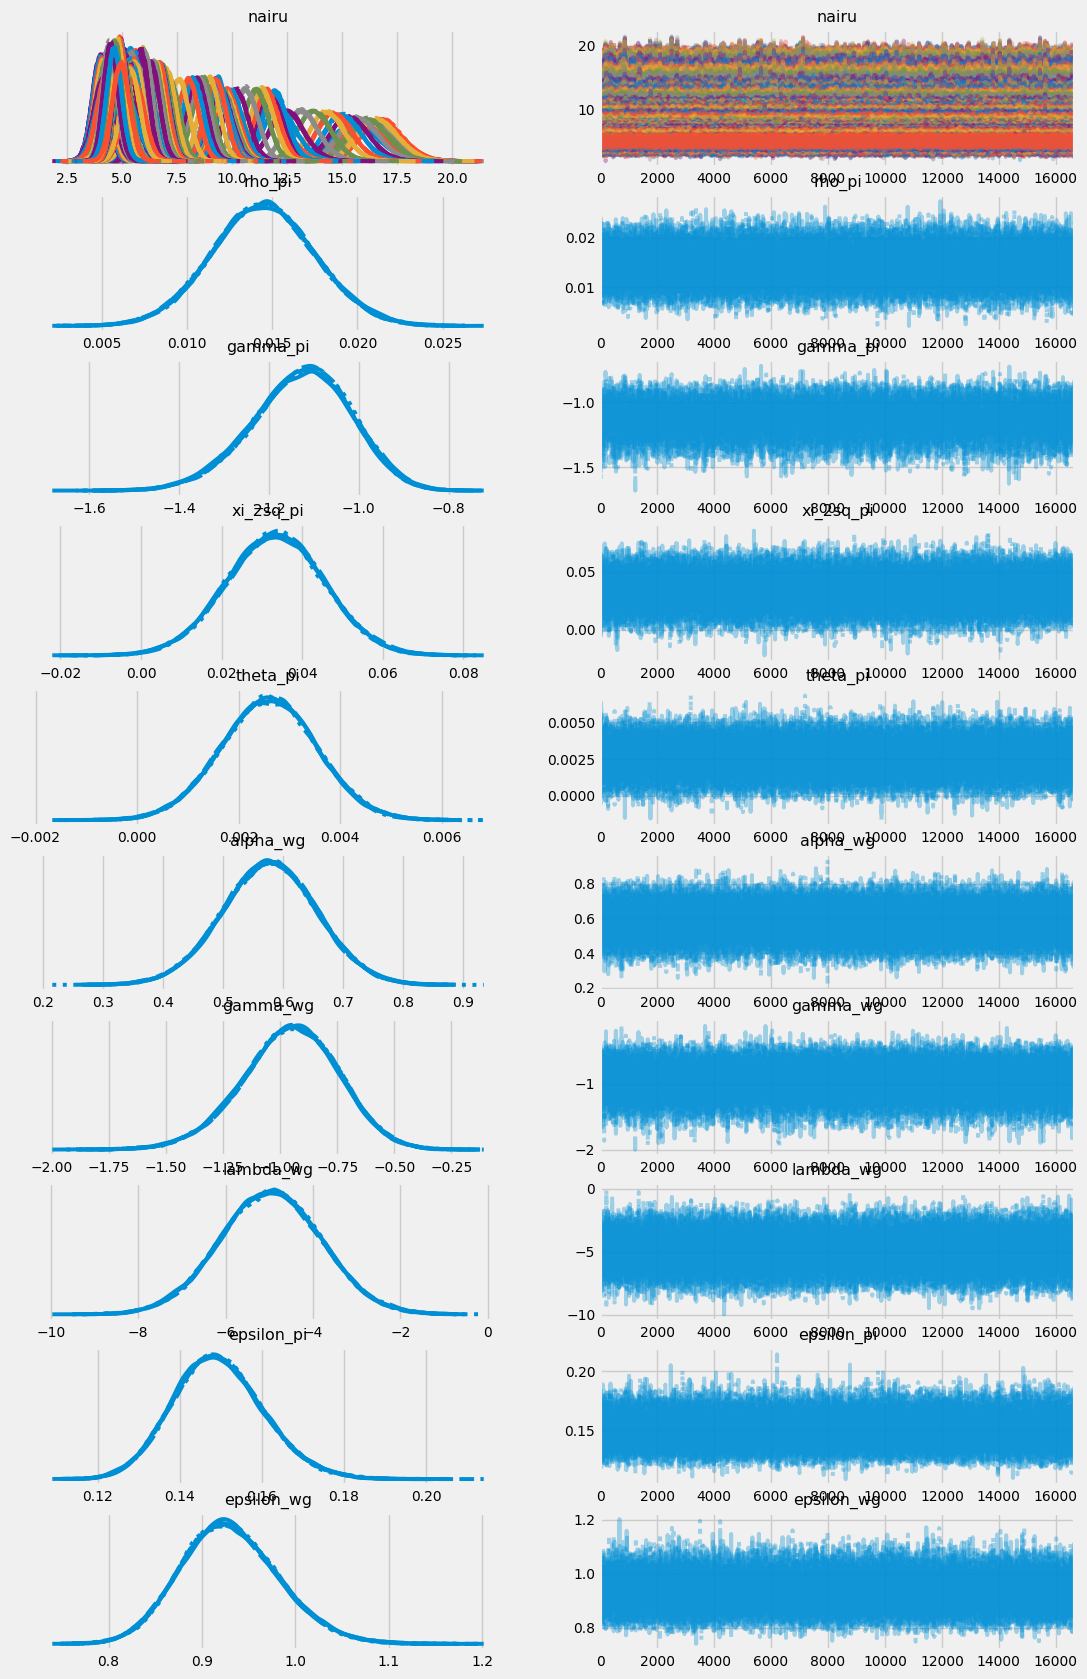

In [20]:
inference_data = fit_the_model(the_model, SAMPLE_ARGS)

## Check diagnostics

In [21]:
check_model_diagnostics(inference_data)

Maximum R-hat convergence diagnostic: 1.0
Minimum effective sample size (ESS) estimate: 8937
Maximum MCSE/sd ratio: 0.010
Divergent transitions: 0/99996 (0.0000%)
Tree depth at max (8): 0.00%
Minimum Bayesian fraction of missing information: 0.85


In [22]:
check_for_zero_coeffs

<function pymc_helper.check_for_zero_coeffs(trace: arviz.data.inference_data.InferenceData, critical_params: list[str] | None = None) -> pandas.core.frame.DataFrame>

## Results

### Plot NAIRU

In [23]:
def plot_nairu(
    trace: az.InferenceData,
    unemployment: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot the NAIRU."""

    start = pd.Period("1985Q1", freq="Q")

    nairu = get_vector_var("nairu", trace)
    nairu.index = input_index.to_timestamp()
    # cuts = [5, 15, 25, 35, 49]
    cuts = [2.5, 16, 49.5]  # align lower two cuts to standard deviations
    colors = [(p - min(cuts)) / (max(cuts) - min(cuts)) for p in cuts]
    min_color_strength = 0.25
    color_fracs = [c * (1.0 - min_color_strength) + min_color_strength for c in colors]
    palette = "Blues"
    _, ax = plt.subplots()
    cmap = plt.get_cmap(palette)

    for i, p in enumerate(cuts):
        quants = p, 100 - p
        label = f"NAIRU {quants[1] - quants[0]:0.0f}% HDI"
        lower, upper = [nairu.quantile(q=q / 100.0, axis=1) for q in quants]
        color = color_fracs[i]
        ax.fill_between(
            nairu.index,
            upper,
            lower,
            color=cmap(color),
            alpha=0.5,
            label=label,
            zorder=i + 1,
        )
    u = unemployment[unemployment.index >= start]
    ax.plot(u.index.to_timestamp(), u, label="_", color="white", lw=3, zorder=9)
    ax.plot(
        u.index.to_timestamp(),
        u,
        label="Unemployment rate",
        color="black",
        lw=1,
        zorder=10,
    )
    inflation = π4[π4.index >= start]
    for color, width in zip(["white", "darkorange"], [3, 1]):
        ax.plot(
            inflation.index.to_timestamp(),
            inflation,
            label="Annual Core Inflation" if width == 1 else "_",
            color=color,
            lw=width,
            zorder=11,
        )

    latest = round(nairu.iloc[-1].quantile(0.5), 1)
    ax.text(
        nairu.index[-1],  # type: ignore[arg-type]
        latest,
        f" {latest}",
        va="center",
        ha="left",
        color="black",
        fontsize=8,
    )

    # mark progressive changes to the NAIRU
    # may need to adjust the x-axis labels.
    ymin, _ymax = ax.get_ylim()
    period = pd.Period("1985Q1", freq="Q")
    while period < input_index[-1]:
        index = period.to_timestamp()
        progress = round(nairu.loc[index].quantile(0.5), 1)
        ax.text(
            index,  # type: ignore[arg-type]
            ymin + 0.2,
            f"{progress}",
            va="bottom",
            ha="center",
            color="black",
            fontsize=8,
        )
        period += 20  # 5 years = 20 quarters

    mg.finalise_plot(
        ax,
        title="NAIRU Estimate for Australia",
        ylabel="Per cent",
        legend={"loc": "upper right", "fontsize": "x-small"},
        lfooter="Australia. What unemployment rate would return inflation to the annual 2.5% target? ",
        **ANNUAL_RANGE,
        **ANNUAL_TARGET,
        show=SHOW,
    )


plot_nairu(inference_data, U, obs_index)

### Table Posterior Samples at Various HDI thresholds

Also warn if free variables not statistically different from zero 

In [24]:
check_for_zero_coeffs(inference_data, critical_params=['gamma_pi', 'gamma_wg'])

,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,Check Significance
alpha_wg,0.392652,0.447765,0.477105,0.525221,0.578357,0.631464,0.679075,0.708348,0.762361,
epsilon_pi,0.125840,0.132237,0.135713,0.141828,0.148968,0.156520,0.163814,0.168385,0.177478,
epsilon_wg,0.818522,0.848375,0.864999,0.893626,0.927527,0.963908,0.998519,1.020031,1.062132,
gamma_pi,-1.402032,-1.317535,-1.272786,-1.199031,-1.122508,-1.051190,-0.990360,-0.955100,-0.893063,
gamma_wg,-1.482432,-1.314996,-1.231359,-1.092156,-0.949102,-0.810045,-0.691870,-0.621366,-0.489591,
lambda_wg,-7.655122,-6.862500,-6.446320,-5.752071,-4.968573,-4.192276,-3.491109,-3.074086,-2.250116,
rho_pi,0.007521,0.009548,0.010625,0.012450,0.014467,0.016481,0.018344,0.019483,0.021571,
theta_pi,0.000382,0.001036,0.001384,0.001960,0.002598,0.003229,0.003806,0.004154,0.004815,
xi_2sq_pi,0.005087,0.013426,0.017875,0.025244,0.033457,0.041545,0.048899,0.053398,0.061628,


### All Posterior Coefficients on a single chart

In [25]:
plot_posteriors_bar(
    inference_data,
    model_name="Joint NAIRU + Outputs Gap",
    show=SHOW,
)

### Plot individual KDEs for each posterior coefficient.

In [26]:
plot_posteriors_kde(
    inference_data,
    model_name="Joint NAIRU + Outputs Gaps",
    show=SHOW,
)

## Finished

In [27]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

Last updated: 2025-12-10 10:01:43

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.8.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

numpy     : 2.3.5
matplotlib: 3.10.7
IPython   : 9.8.0
pymc      : 5.26.1
readabs   : 0.1.8
typing    : 3.10.0.0
mgplot    : 0.2.14
arviz     : 0.22.0
pandas    : 2.3.3

Watermark: 2.5.0

